# The Cropland Data Layer
### Exploring US Crop Production


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import pyproj
import rasterio
import rasterstats
import pandas as pd
import json
from rasterio.mask import mask
from rasterio.plot import show

In [14]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

### The Central Valley
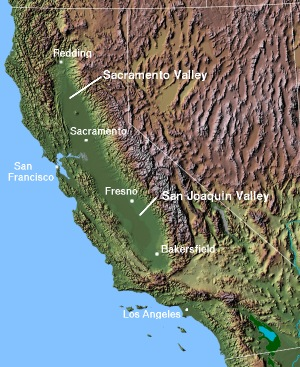

- Produces more than half of the country's fruits, nuts, and vegetables.
- Productive agricultural area because of extensive canals and irrigation (naturally can be quite arid).

Why is fallowing important?
- A way to give the land rest to improve future productivity.
- May also be a decision to take land out of production.

### Step 1: Read in the Counties

In [2]:
# Read in file
counties = geopandas.read_file("../../Data/Images/cb_2017_us_county_500k/cb_2017_us_county_500k.shp")

CA = counties[counties.STATEFP=="06"]

In [3]:
CA.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
18,06,001,01675839,0500000US06001,06001,Alameda,06,1909616630,216916717,"POLYGON ((-122.34225 37.80556, -122.33412 37.8..."
19,06,005,01675841,0500000US06005,06005,Amador,06,1539933576,29470568,"POLYGON ((-121.02741 38.50354, -121.02747 38.5..."
20,06,013,01675903,0500000US06013,06013,Contra Costa,06,1857310903,225193562,"POLYGON ((-122.42976 37.96540, -122.41859 37.9..."
21,06,023,01681908,0500000US06023,06023,Humboldt,06,9241251740,1254039383,"POLYGON ((-124.40860 40.44320, -124.39664 40.4..."
22,06,037,00277283,0500000US06037,06037,Los Angeles,06,10510588451,1794793532,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987..."


<AxesSubplot:>

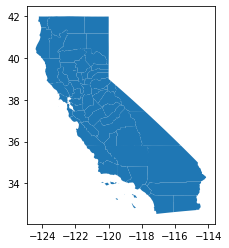

In [4]:
CA.plot()

### Step 2: Read in raster files

In [5]:
r17 = rasterio.open("../../Data/Images/Central_Valley/CDL_2017_clip_20210316212728_848680512.tif")
r18 = rasterio.open("../../Data/Images/Central_Valley/CDL_2018_clip_20210316212728_848680512.tif")
r19 = rasterio.open("../../Data/Images/Central_Valley/CDL_2019_clip_20210316212728_848680512.tif")
r20 = rasterio.open("../../Data/Images/Central_Valley/CDL_2020_clip_20210316212728_848680512.tif")

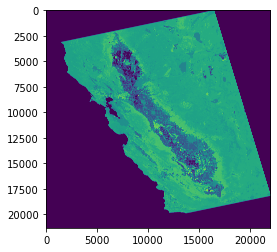

In [6]:
plt.imshow(r20.read(1))

In [7]:
r20.crs==CA.crs

False

In [8]:
r20.crs,CA.crs

(CRS.from_epsg(4326),
 <Geographic 2D CRS: EPSG:4269>
 Name: NAD83
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: North America - NAD83
 - bounds: (167.65, 14.92, -47.74, 86.46)
 Datum: North American Datum 1983
 - Ellipsoid: GRS 1980
 - Prime Meridian: Greenwich)

<AxesSubplot:>

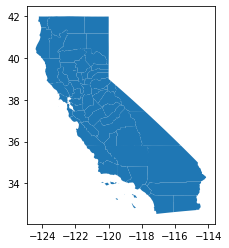

In [9]:
CA = CA.to_crs(r17.crs)

CA.plot()

### Step 3: Clipping the raster.

First we need a state polygon.

In [10]:
CA_State = CA.dissolve(by="STATEFP",aggfunc="sum")

I made a function to do the clipping for me.

In [15]:
def clip_raster(raster,vector,filename):
    img_out, img_transform = mask(raster,getFeatures(vector))
    
    out_meta = raster.meta.copy()

    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = img_transform

    with rasterio.open("./"+filename+".tif", "w", **out_meta) as dest:
        dest.write(img_out)
    
    return rasterio.open("./"+filename+".tif")

In [16]:
r17_c = clip_raster(r17,CA_State,"CA17_CDL")
r18_c = clip_raster(r18,CA_State,"CA18_CDL")
r19_c = clip_raster(r19,CA_State,"CA19_CDL")
r20_c = clip_raster(r20,CA_State,"CA20_CDL")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
show(r17_c, ax=ax,cmap="Greens")
CA.plot(ax=ax, facecolor='none', edgecolor='black')

Successfully clipped it. Now what exactly are the land uses here?

In [17]:
r17_array = r17_c.read(1)
pixels = pd.Series(r17_array.flatten())

pixels = pixels[pixels!=0]

In [18]:
pixel_counts = pixels.value_counts()
pixel_counts.head(10)

152    63533094
142    46230329
176    35025259
121     6766306
131     5714682
143     5630388
75      5500830
61      5454332
69      3558428
123     3153930
dtype: int64

### Step 4: Pixel Counts 

What are these pixels? One of your exercises in the homework is to make a dictionary (by hand) such that you can do this:

In [19]:
with open("../../Data/Images/CDL_dict.json") as f:
    pixel_names = json.load(f)[0]

In [20]:
pixel_ixs = pd.Series(pixel_counts.index).astype(str)
pixel_ixs.replace(pixel_names).head(10)

0                  Shrubland
1           Evergreen Forest
2          Grassland/Pasture
3       Developed/Open Space
4                     Barren
5               Mixed Forest
6                    Almonds
7       Fallow/Idle Cropland
8                     Grapes
9    Developed/Med Intensity
dtype: object

In [21]:
pixel_counts.index = pixel_ixs.replace(pixel_names)
pixel_counts.head(10)

Shrubland                  63533094
Evergreen Forest           46230329
Grassland/Pasture          35025259
Developed/Open Space        6766306
Barren                      5714682
Mixed Forest                5630388
Almonds                     5500830
Fallow/Idle Cropland        5454332
Grapes                      3558428
Developed/Med Intensity     3153930
dtype: int64

Potentially not useful. Let's find percentage.

In [22]:
# Method 1:
pixel_counts = pixels.value_counts()

pixel_ixs = pd.Series(pixel_counts.index).astype(str)

pixel_counts.index = pixel_ixs.replace(pixel_names)

(pixel_counts/pixel_counts.sum()*100).head(10)

Shrubland                  30.397085
Evergreen Forest           22.118665
Grassland/Pasture          16.757657
Developed/Open Space        3.237305
Barren                      2.734160
Mixed Forest                2.693830
Almonds                     2.631844
Fallow/Idle Cropland        2.609597
Grapes                      1.702512
Developed/Med Intensity     1.508982
dtype: float64

In [23]:
# Method 2:
pixel_counts = pixels.value_counts(normalize=True)*100

pixel_ixs = pd.Series(pixel_counts.index).astype(str)

pixel_counts.index = pixel_ixs.replace(pixel_names)

pixel_counts.head(10)

Shrubland                  30.397085
Evergreen Forest           22.118665
Grassland/Pasture          16.757657
Developed/Open Space        3.237305
Barren                      2.734160
Mixed Forest                2.693830
Almonds                     2.631844
Fallow/Idle Cropland        2.609597
Grapes                      1.702512
Developed/Med Intensity     1.508982
dtype: float64

So 30% of our land mass is shrubland, 22% forest, 16% pasture, and the rest other things.

Visualizing with a pie chart can happen, but can be a bit awkward given how many labels there are:

In [24]:
pixel_counts = pixels.value_counts()

pixel_ixs = pd.Series(pixel_counts.index).astype(str)

pixel_counts.index = pixel_ixs.replace(pixel_names)

<AxesSubplot:ylabel='None'>

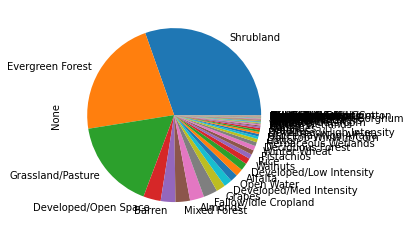

In [25]:
pixel_counts.plot(kind="pie")

Not helpful at all...

In [26]:
condensed_counts = pixel_counts.iloc[:3]
condensed_counts.loc["Other"] = pixel_counts.iloc[3:].sum()

<AxesSubplot:ylabel='None'>

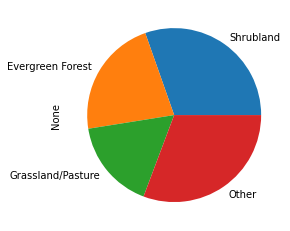

In [27]:
condensed_counts.plot(kind="pie")


What could we do?

We could try labeling pixels in a more aggregate way"

In [28]:
pixel_counts = pixels.value_counts()
pixel_counts = pixel_counts.reset_index()
pixel_counts.columns =["val","count"]
pixel_counts['label'] = pixel_counts['val'].astype(str).replace(pixel_names)

In [29]:
pixel_counts.loc[pixel_counts.val<20,"type"]= "Crop"
pixel_counts.loc[(pixel_counts.val>=20)&(pixel_counts.val<40),"type"]= "Crop"
pixel_counts.loc[(pixel_counts.val>=40)&(pixel_counts.val<61),"type"]= "Crop"
pixel_counts.loc[(pixel_counts.val>=61)&(pixel_counts.val<66),"type"]= "Other"
pixel_counts.loc[(pixel_counts.val>=66)&(pixel_counts.val<80),"type"]= "Crop"
pixel_counts.loc[(pixel_counts.val>=81)&(pixel_counts.val<120),"type"]= "Other"
pixel_counts.loc[(pixel_counts.val>=120)&(pixel_counts.val<125),"type"]= "Developed"
pixel_counts.loc[(pixel_counts.val>=125)&(pixel_counts.val<140),"type"]= "Other"
pixel_counts.loc[(pixel_counts.val>=141)&(pixel_counts.val<144),"type"]= "Forest"
pixel_counts.loc[(pixel_counts.val>=144)&(pixel_counts.val<190),"type"]= pixel_counts['label']
pixel_counts.loc[(pixel_counts.val>=190)&(pixel_counts.val<200),"type"]= "Other"
pixel_counts.loc[(pixel_counts.val>=196),"type"]= "Crop"

Text(0, 0.5, '')

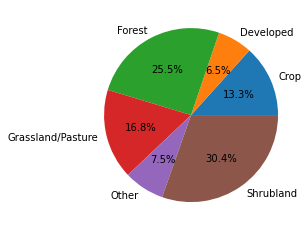

In [30]:
pixel_counts.groupby("type")['count'].sum().plot(kind="pie",autopct='%1.1f%%')
plt.ylabel("")

Or even this:

Text(0, 0.5, '')

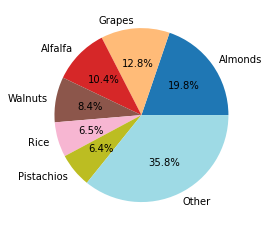

In [31]:
crop_counts = pixel_counts[pixel_counts.type=="Crop"].set_index("label")['count']

top_crops = crop_counts.iloc[:6]
top_crops.loc["Other"] = crop_counts.iloc[6:].sum()

top_crops.plot(kind="pie",cmap="tab20",autopct='%1.1f%%',radius=1)
plt.ylabel("")

### Step 5: Visualizing Cropland
How else could we approach this?

We could do a masking approach as before:

In [33]:
crop_mask = (r17_array>0)&((r17_array<80)|(r17_array>195))

r17_array[~crop_mask]= 0

img_out = r17_array[np.newaxis,:,:]

out_meta = r17_c.meta.copy()

out_meta['height'] = img_out.shape[1]
out_meta['width'] = img_out.shape[2]
out_meta['dtype'] = "uint8"
out_meta['transform'] = r17_c.transform

with rasterio.open("./crop_layer17.tif", "w", **out_meta) as dest:
    dest.write(img_out)

In [34]:
c17 = rasterio.open("./crop_layer17.tif","r+") # The r+ allows me to set the no-data value.
c17.nodata = 0

In [35]:
temp = pd.Series(c17.read(1).flatten()).value_counts()
temp.index= pd.Series(temp.index).astype(int).astype(str).replace(pixel_names)
temp

Background              436239115
Almonds                   5500830
Fallow/Idle Cropland      5454332
Grapes                    3558428
Alfalfa                   2885496
                          ...    
Canola                        839
Asparagus                     743
Apples                        682
Blueberries                   396
Mint                            2
Length: 68, dtype: int64

So now we turned all the non-crop pixels into zeros. We can visualize what it looks like by examining a binary array:

In [36]:
c17_array = c17.read(1).astype(float)
c17_binary = c17_array!=0

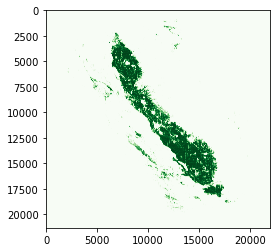

In [37]:
plt.imshow(c17_binary,cmap="Greens")

Now we see the Central Valley quite clearly.

Let's now turn to analyzing fallowing patterns. How would we do this?

### Step 6: Extracting Fallowing Patterns

Essentially, we want to know whether between two years how pixels change from three, discrete outcomes:

$p_{it} = \{Crop, Fallowed, Other\}$

if $T$ is the number of years, this leaves $3^T$ possible outcomes.

Let's start with examining a combination of two years which leaved $9$ outcomes:

$ \{\{C,C\},\{C,F\},\{C,O\},\{F,C\},\{F,F\},\{F,O\},\{O,C,\},\{O,F\},\{O,O\}\}$

In [38]:
def raster_cfo(raster,filename):
    x = raster.read(1)
    img_out = np.zeros(x.shape) # 0 for other
    
    crop_mask = (x>0)&((x<80)|(x>195))
    fallow_mask = x==61
    
    img_out[crop_mask] = 1 # 1 for crops
    img_out[fallow_mask] = 2 # 2 for fallow
    
    img_out = img_out[np.newaxis,:,:].astype(np.uint8)
    
    out_meta = raster.meta.copy()

    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = raster.transform
    out_meta['dtype'] = "uint8"

    with rasterio.open("./"+filename+".tif", "w", **out_meta) as dest:
        dest.write(img_out)
    
    return rasterio.open("./"+filename+".tif")

In [39]:
cfo17 = raster_cfo(r17_c,"cfo17")
cfo18 = raster_cfo(r18_c,"cfo18")

### Step 7: Visualizing Fallowing Patterns

In [40]:
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.colors

labels = {0:"Other",
          1:"Crops",
          2:"Fallowed"}

cmap = matplotlib.colors.ListedColormap(['white', "C3","C0"])

patches =[mpatches.Patch(color=cmap(i),label=labels[i]) for i in labels.keys()]

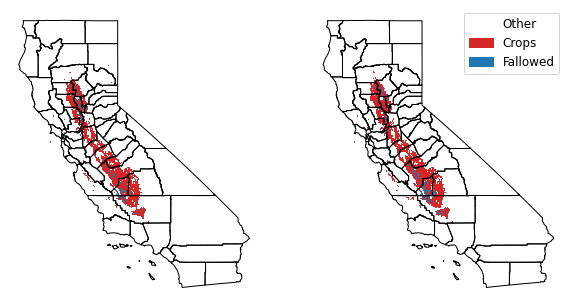

In [47]:
fig, ax = plt.subplots(1,2,figsize=(10, 10))

# 2017
rasterio.plot.show(cfo17,cmap=cmap,ax=ax[0])
CA.plot(ax=ax[0], facecolor='none', edgecolor='black')
ax[0].axis('off')

# 2018
rasterio.plot.show(cfo18,cmap=cmap,ax=ax[1])
CA.plot(ax=ax[1], facecolor='none', edgecolor='black')
ax[1].axis('off')

plt.legend(handles=patches,fontsize=12)

Not easy to tell at this scale, let's zoom in

(-123.0, -118.5, 34.8, 40.5)

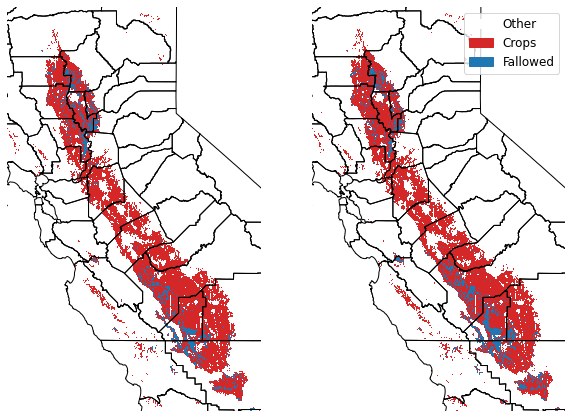

In [48]:
fig, ax = plt.subplots(1,2,figsize=(10, 10))

# Plot 2017
rasterio.plot.show(cfo17,cmap=cmap,ax=ax[0])
CA.plot(ax=ax[0], facecolor='none', edgecolor='black')
ax[0].set_xlim(-123,-118.5)
ax[0].set_ylim(34.8,40.5)
ax[0].axis("off")

# Plot 2018
rasterio.plot.show(cfo18,cmap=cmap,ax=ax[1])
CA.plot(ax=ax[1], facecolor='none', edgecolor='black')
ax[1].set_xlim(-123,-118.5)
ax[1].set_ylim(34.8,40.5)
ax[1].axis("off")

plt.legend(handles=patches,fontsize=12)
plt.axis('off')

How do we visualize changes? We could give each pattern a different color.

To make it coherent, we will just use 4 categories.

In [50]:
def visualize_rotate(y1,y2,filename):
    a1 = y1.read(1)
    a2 = y2.read(1)
    
    C_to_C = (a1==1)&(a2==1)
    C_to_F = (a1==1)&(a2==2)
    F_to_C = (a1==2)&(a2==1)
    F_to_F = (a1==2)&(a2==2)
    
    a = np.zeros(a1.shape)
    
    a[C_to_C] = 1
    a[C_to_F] = 2
    a[F_to_C] = 3
    a[F_to_F] = 4
    
    img_out = a[np.newaxis,:,:].astype(np.uint8)
    
    out_meta = y1.meta.copy()

    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = y1.transform
    out_meta['dtype'] = "uint8"

    with rasterio.open("./"+filename+".tif", "w", **out_meta) as dest:
        dest.write(img_out)
    
    return rasterio.open("./"+filename+".tif")

In [51]:
rotate_labels = {0:"Background",
                 1:"Crop to Crop",
                 2:"Crop to Fallow",
                 3:"Fallow to Crop",
                 4:"Fallow to Fallow"}

In [52]:
cf_17_18 = visualize_rotate(cfo17,cfo18,"cfo_17_18")

In [53]:
rotate_counts = pd.Series(cf_17_18.read(1).flatten()).value_counts().iloc[1:]
rotate_counts.index = pd.Series(rotate_counts.index).replace(rotate_labels)
rotate_counts/rotate_counts.sum()*100

Crop to Crop        74.931607
Fallow to Fallow    11.043039
Crop to Fallow       8.787510
Fallow to Crop       5.237844
dtype: float64

About 14% of pixels are rotating. Let's now visualize it:

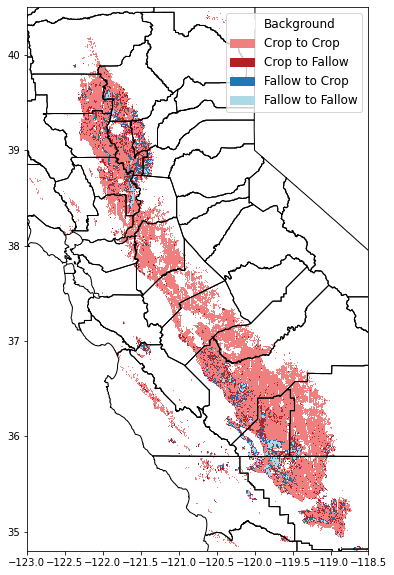

In [57]:
fig, ax = plt.subplots(figsize=(10, 10))

cmap = matplotlib.colors.ListedColormap(["white","lightcoral","firebrick", 'C0','lightblue'])

patches =[mpatches.Patch(color=cmap(i),label=rotate_labels[i]) for i in rotate_labels.keys()]

# Plot 2017-2018
rasterio.plot.show(cf_17_18 ,cmap=cmap,ax=ax)
CA.plot(ax=ax, facecolor='none', edgecolor='black')
ax.set_xlim(-123,-118.5)
ax.set_ylim(34.8,40.5)
# ax.axis("off")

plt.legend(handles=patches,fontsize=12)


Let's zoom in...

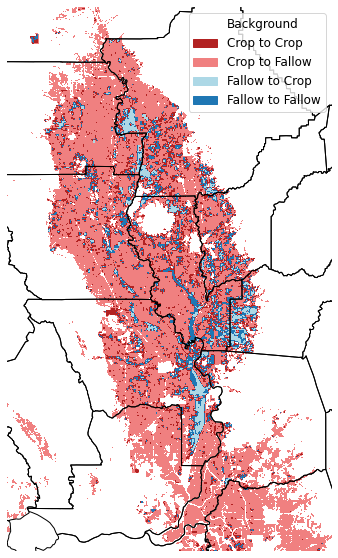

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))

cmap = matplotlib.colors.ListedColormap(["white","lightcoral","firebrick", 'C0','lightblue'])

# Plot 2017-2018
rasterio.plot.show(cf_17_18 ,cmap=cmap,ax=ax)
CA.plot(ax=ax, facecolor='none', edgecolor='black')
ax.set_xlim(-122.5,-121)
ax.set_ylim(38,40)
ax.axis("off")

plt.legend(handles=patches,fontsize=12)

### Step 8: Interpretation

Why do you think the patterns might look like this?